# Predict students' graduation rate

dataset 
- [from @ roycekimmons.com](http://roycekimmons.com/tools/generated_data/graduation_rate)

> This is a fictional dataset and should only be used for data science training purposes.
> 
> This data set includes graduation rates from a four-year college with a variety of student factors.

The key questions we want to address:

> 1. How effective are entrance requirements at predicting gpa and graduation rate?
> 1. What would be the best way to improve graduation rates?

> All data sets are generated on-the-fly. So, you can increase your n by downloading a data set multiple times and combining the files. (n=1000) per large sample download

Based on the above statement, I have downloaded 5x times and combined them into one csv file so that we can work with a larger sample size of 5000 observations, instead of just 1000 observations.

Target is `'graduate_in_5years'` and column named simply as `'target'`
- feature-engineered from 'years_to_graduate' as 
  - 0: 'Yes' ie 'years_to_graduate' < 6
  - 1: 'No' ie 'years_to_graduate' > 5 
- was set to 4 years initially until EDA reveals median is 5.


In [76]:
import sys
from pathlib import Path
import logging
from contextlib import redirect_stdout

# Configure the logging library.
logging.basicConfig(filename='hyperparam_tuning.log', level=logging.INFO)

# Set the path to the current file 
current_file_path = Path().resolve()
print(f'{current_file_path = } ')

# Set the path to the data folder
data_folder_path = current_file_path / 'data'
print(f'{data_folder_path = } ')

# Set the path to the src folder
src_folder_path = current_file_path / 'src'
print(f'{src_folder_path = } ')

# Add the src folder to the system path
sys.path.append(str(src_folder_path))

# Import modules from files under /src
from config import * 
from src.data_loader import CSVDataLoader
from src.data_preprocessor import Preprocessor
from src.data_feature_builder import FeatureBuilder
from src.trainer import *
from src.predictor import *

current_file_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms') 
data_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/data') 
src_folder_path = WindowsPath('B:/repos/Courses/DataTalksClub/mlzoomcamp-midterms/src') 


## Import packages

In [77]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [78]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import HistGradientBoostingClassifier

import catboost
from catboost import *
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [79]:
import sklearn
sklearn.__version__

'1.2.2'

## Overview

> do we want 
> - 2 splits for train, test or 
> - 3 splits for train, val and test?
>
> reminder: 
> - not yet stratify
> - not scaled
> - use cross-validation 
> - save final df to file as processed_df.csv?

In this notebook, we're finally going to address the above questions. We're using 
- KFolds to cross-validate our data splitting,
- using just 3 features that were shown as the most important features via EDA
- scale our data, treat outliers using Pipelines,
- perform hyperparameters tuning on the 2 classifiers with highest `'val auc'` scores,
- finally, the final chosen "best model" would be identified, and 
- creating scripts out of our POC code would start, that would allow
- save our model to a `.pkl` file for our deployed model to a web servic.e


## Hyperparameters Tuning

### Putting it all together

Based on findings from baseline scoring, we're gonna limit our GridSearch and hyperparameters tuning to just these 2 classifiers.

Perform data preprocessing and use pipelines to perform hyperparameter tuning to a couple of the models from previous top 2 performers:

- HistGradientBoostingClassifier()
- CatBoostClassifier()


In [80]:
# declare the 3 features we using to train the model
features = ['parental_income', 'sat_total_score', 'college_gpa'] 
# graduate_in_5years simply labeled as 'target'
target_name = 'target'

In [81]:
# Data ingestion
def rebuild_df(features=None):
    print(f'{TARGET_NAME = }')
    data = CSVDataLoader().load('data/graduation_rate.csv')
    print(f'{features = }')
    print()

    print("- Preprocessor()...")
    data = Preprocessor().ColumnsSymbolReplacer(data)
    # display(data.head(2))
    data = Preprocessor().SymbolReplacer(data, 'parental_level_of_education')
    # display(data.head(2))
    data = Preprocessor().ColumnsDropper(data, TO_DROP)
    # display(data.head(2))
    print()
    print("- FeatureBuilder()...")
    data = FeatureBuilder().TargetEncoder(data)
    print("  - Set COLS_CATEGORICAL astype(category)...")
    data[COLS_CATEGORICAL] = data[COLS_CATEGORICAL].astype('category')
    print()
    print("- Prepare DFs...")
    print("  -- Split TARGET_NAME for y...")
    target = data[TARGET_NAME]
    print("  -- Dropping TARGET_NAME...")
    data = data.drop(columns=TARGET_NAME)
    
    if features:
        data = data[features]
    
    df_full_train, df_test, y_full_train, y_test = train_test_split(data, target, test_size=0.2, random_state=11)
    
    return df_full_train, df_test, y_full_train, y_test

In [ ]:
df_full_train, df_test, y_full_train, y_test = rebuild_df(features)

df_full_train.head()

### Hyperparams Tuning on HistGradientBoostingClassifier

#### setup

In [ ]:
# initialize
scores = []
fold = 0

# Create a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

hist_param_grid = {
    'classifier__learning_rate': LEARNING_RATE,
    'classifier__max_iter': MAX_ITER,
    'classifier__max_depth': MAX_DEPTH,
    'classifier__min_samples_leaf': MIN_SAMPLES_LEAF, 
    'classifier__early_stopping': ['auto', True],
    'classifier__class_weight': WEIGHTS
}

# Create the pipeline
pipe = Pipeline([
    ('outlier_treatment', QuantileTransformer() ),
    ('scaler',  StandardScaler() ),
    ('classifier', 
     HistGradientBoostingClassifier(verbose=5, scoring='f1_weighted', warm_start=True, random_state=42)
    )
])

# Create a GridSearchCV object
grid_search = GridSearchCV(
    pipe, 
    hist_param_grid, 
    cv=kfold, 
    error_score='raise', 
    return_train_score=True,
    refit=True,
    verbose=2,
    n_jobs=-1
)

#### train

In [ ]:
%%capture output   
# Log the output of each step of the tuning process.
logging.info('Starting HistGradientBoostingClassifier hyperparam tuning...')

# Fit the pipeline to the train data and perform hyperparameter tuning
for train_idx, val_idx in kfold.split(df_full_train):
    
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = target[train_idx].values
    y_val = target[val_idx].values
    
    logging.info(f'-- in grid_search.fit(); kfold: {fold} --')
    fold = fold + 1

    logging.info('Fitting GridSearchCV model...')
    with open('hyperparam_tuning.log', 'a') as f:
        with redirect_stdout(f):
            # Train the model on the train data
            grid_search.fit(df_train, y_train)
    logging.info('GridSearchCV fit completed')
    
# this cell took approx 45mins on my machine! 

#### predict

In [ ]:
# Make predictions on the validate data
y_pred_train = grid_search.predict(df_train)
y_pred_val = grid_search.predict(df_val)

# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "val auc": roc_auc_score(y_val, y_pred_val),
    "accuracy": accuracy_score(y_val, y_pred_val),
    "precision": precision_score(y_val, y_pred_val),
    "f1_mean": f1_score(y_val, y_pred_val),
    "recall": recall_score(y_val, y_pred_val),   
    }
)
logging.info(f'-- HistGradientBoostingClassifier val scores appended --')

# Log the results of the tuning process.
logging.info('Finished HistGradientBoostingClassifier hyperparam tuning. The best hyperparameters are: {}'.format(grid_search.best_params_))

In [ ]:
# logging.close()
print(f"The best set of parameters is: {grid_search.best_params_}")

#### evaluate

[source](https://inria.github.io/scikit-learn-mooc/python_scripts/parameter_tuning_parallel_plot.html) for `shorten_param` code snippet

In [ ]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head(3).T

In [ ]:
cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

In [ ]:
cv_results.columns

In [ ]:
cv_results = cv_results.sort_index()

In [ ]:
compare = cv_results[['mean_train_score', 'mean_test_score', 'rank_test_score']]
compare.plot()

In [ ]:
# Displaying a Pipeline with a Preprocessing Step and Regression
from sklearn import set_config
set_config(display="diagram")

grid_search

#### Best model training and prediction

In [ ]:
# {'classifier__class_weight': None, 'classifier__early_stopping': True, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__max_iter': 100, 'classifier__min_samples_leaf': 10}

best_params = grid_search.best_params_
best_hist = HistGradientBoostingClassifier(best_params)

# best_hist = HistGradientBoostingClassifier(
#     class_weight=None, 
#     early_stopping=True, 
#     learning_rate=0.1, 
#     max_depth=8, 
#     max_iter=100, 
#     min_samples_leaf=10)
best_hist.fit(df_train, y_train)

y_pred_train = best_hist.predict(df_train)

# using unseen test data
y_test = y_test.values
y_pred_test = best_hist.predict(df_test)
# compile the scores in a list
scores.append({
    "model": "HistGradientBoostingClassifier",
    "train auc": roc_auc_score(y_train, y_pred_train),
    "test auc": roc_auc_score(y_test, y_pred_test),
    "accuracy": accuracy_score(y_test, y_pred_test),
    "precision": precision_score(y_test, y_pred_test),
    "f1_mean": f1_score(y_test, y_pred_test),
    "recall": recall_score(y_test, y_pred_test),   
    }
)
logging.info(f'-- best_hist test scores appended --')

### Hyperparams Tuning on CatBoostClassifier

#### setup

In [82]:
df_full_train, df_test, y_full_train, y_test = rebuild_df()
df_full_train.head()

scores = []

logging.info('Starting CatboostClassifier...')
params = {}
params['loss_function'] = 'Logloss' # RMSE, AUC all not valid
params['iterations'] = 80
params['custom_loss'] = ['Accuracy', 'AUC', 'F1','Precision', 'Recall']
params['random_seed'] = 42
params['learning_rate'] = 0.5

TARGET_NAME = 'target'
Loading CSV data...


100%|██████████| 10/10 [00:00<00:00, 232.55it/s]
INFO:sklearnex: sklearn.model_selection.train_test_split: fallback to original Scikit-learn
INFO:sklearnex: sklearn.model_selection.train_test_split: running accelerated version on CPU


Finished processing the CSV file.
df.shape = (5000, 7)
features = None

- Preprocessor()...
  -- Replacing symbols in column names...
  -- Replacing symbols in data...
  -- Dropping TO_DROP columns...

- FeatureBuilder()...
  -- Creating 'target' column...
  - Set COLS_CATEGORICAL astype(category)...

- Prepare DFs...
  -- Split TARGET_NAME for y...
  -- Dropping TARGET_NAME...


#### train

In [83]:
%%capture output  

logging.info('-- Starting cross validation...')
# %%capture and redirect not working with catboost
# with open('hyperparam_tuning.log', 'a') as f:
#     with redirect_stdout(f):
cv_data = cv(
    params = params,
    pool = Pool(df_full_train, label=y_full_train, cat_features=COLS_CATEGORICAL),
    fold_count=5,           # defaults=3, using  5 to compare with HistGradBoost
    early_stopping_rounds=20,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    # logging_level='Info', # one or the other with 'verbose', cannot both
    verbose=False,         # one or the other with 'logging_level', cannot both
    as_pandas=True
)
logging.info('-- Completed cross validation...')


Training on fold [0/5]

bestTest = 0.5451060805
bestIteration = 4

Training on fold [1/5]

bestTest = 0.5284605903
bestIteration = 10

Training on fold [2/5]

bestTest = 0.5637857804
bestIteration = 4

Training on fold [3/5]

bestTest = 0.5433614436
bestIteration = 3

Training on fold [4/5]

bestTest = 0.5583531198
bestIteration = 4



In [84]:
cv_data.head().T

,0,1,2,3,4
iterations,0.000000,1.000000,2.000000,3.000000,4.000000
test-Logloss-mean,0.589727,0.560800,0.552230,0.549723,0.549088
test-Logloss-std,0.009588,0.009532,0.011054,0.013480,0.012697
train-Logloss-mean,0.585473,0.553399,0.541857,0.535683,0.531003
train-Logloss-std,0.003378,0.004184,0.003844,0.003974,0.003200
test-Accuracy-mean,0.740242,0.744497,0.743498,0.744747,0.745249
test-Accuracy-std,0.018942,0.016318,0.014760,0.016258,0.014087
train-Accuracy-mean,0.742064,0.748438,0.752375,0.752437,0.754312
train-Accuracy-std,0.008905,0.004519,0.002815,0.002822,0.002270
test-AUC-mean,0.644894,0.657500,0.667068,0.671012,0.670816


In [85]:
best_value = np.min(cv_data['test-AUC-mean'])
best_iter = np.argmin(cv_data['test-AUC-mean'])

print('Best validation AUC score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter)
)

Best validation AUC score, stratified: 0.6445±0.0167 on step 29


In [86]:
scores = []
# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
    "train logloss": np.min(cv_data['train-Logloss-mean']),
    "val logloss": np.min(cv_data['test-Logloss-mean']),
    "accuracy": np.min(cv_data['test-Accuracy-mean']),
    "precision": np.min(cv_data['test-Precision-mean']),
    "f1_mean": np.min(cv_data['test-F1-mean']),
    "recall": np.min(cv_data['test-Recall-mean']),
    }
)
logging.info(f'-- CatBoostClassifier scores appended --')

# Log the results of the tuning process.
# logging.info('Finished CatBoostClassifier hyperparam tuning. The best hyperparameters are: {}'.format(grid_search.best_params_))

#### predict

In [87]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(df_val, y_val, cat_features=COLS_CATEGORICAL)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

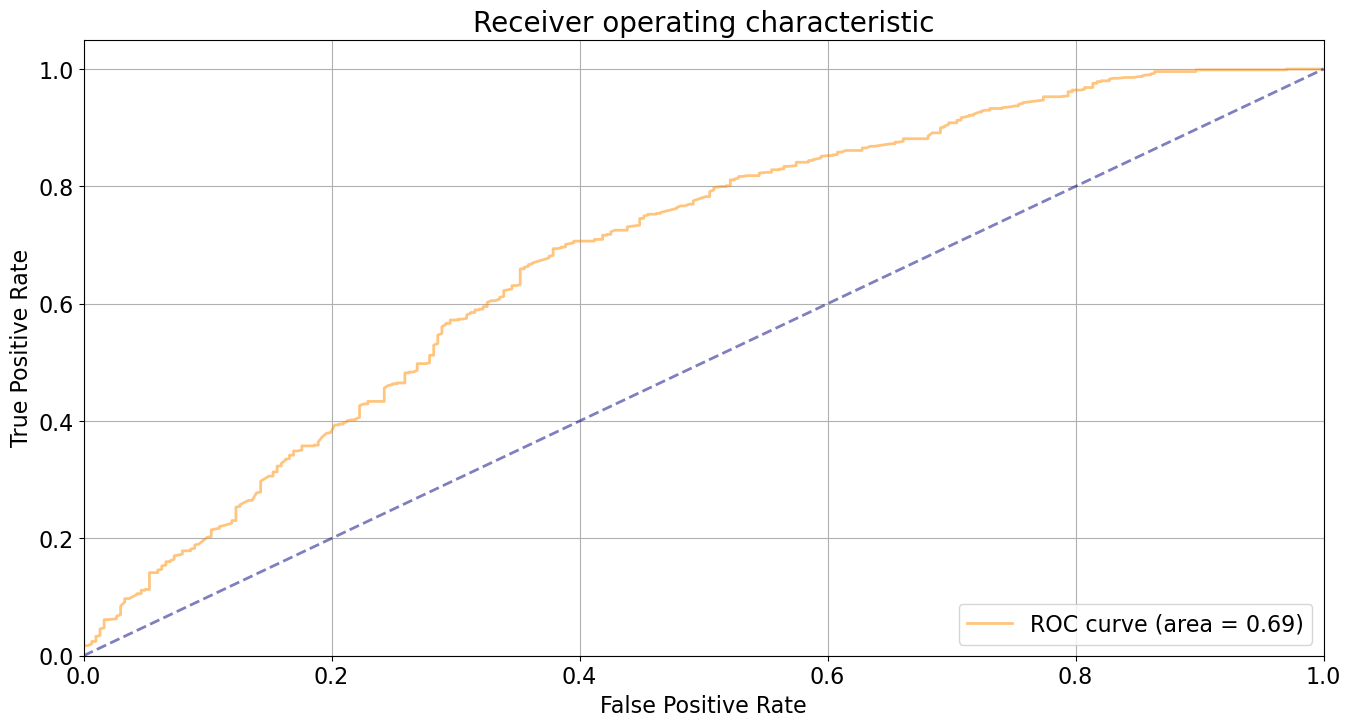

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### evaluate

In [89]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,college_gpa,52.910607
1,parental_income,25.342582
2,sat_total_score,19.233452
3,parental_level_of_education,2.513360


#### Model comparison

In [90]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learning_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=1000,
    random_seed=0,
    train_dir='learning_rate_0.01'
)
model1.fit(
    df_train, y_train,
    eval_set=(df_val, y_val),
    cat_features=COLS_CATEGORICAL,
    verbose=False
)
model2.fit(
    df_train, y_train,
    eval_set=(df_val, y_val),
    cat_features=COLS_CATEGORICAL,
    verbose=False
)

In [ ]:
from catboost import MetricVisualizer
MetricVisualizer(['learning_rate_0.01', 'learning_rate_0.7']).start()

#### Best iteration

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
    use_best_model=False
)
model.fit(
    df_train, y_train,
    cat_features=COLS_CATEGORICAL,
    eval_set=(df_val, y_val),
    verbose=False,
    plot=True
)

#### Best model training and prediction

In [ ]:
grid_search.best_params_

In [ ]:
best_params = grid_search.best_params_
# best_cat = CatBoostClassifier(best_params)
best_cat = CatBoostClassifier(
    depth=6,
    early_stopping_rounds=5,
    iterations=100,
    learning_rate=0.001,
    loss_function='Logloss'    
)
best_cat.fit(df_train, y_train)

y_pred_train = best_cat.predict(df_train)
y_pred_test = best_cat.predict(df_test)

# compile the scores in a list
scores.append({
    "model": "CatBoostClassifier",
  
    }
)
logging.info(f'-- best_cat test scores appended --')

## Final Model output

using df_test and the best_params

In [ ]:
df = pd.DataFrame(scores)
df